#**Chapter 5: The Mechanics of Learning**
*  Understanding how algorithms can learn from data
*  Reframing learning as parameter estimation, using differentiation and gradient descent
*  Walking through a very simple learning algorithm from scratch
*  How PyTorch supports learning with autograd

In [1]:
#Importing Necessary Libraries
import numpy as np
import torch
%matplotlib inline
torch.set_printoptions(edgeitems=2,linewidth=75)

## **5.2. PyTorch's Autograd: Back-propagate All Things**

Why we need Autograd? 
In the previous experiment, we performed backpass or back-propagation using chain rule by explicitly write the derivatives funtion one by one. But, what if we have complicated model with millions of parameters? Then, writing the analytical expression for the derivatives of a very deep composition of linear and non-linear functions is not a lot of fun. That is when Autograd is used. Because, given a forward expression, no matter how nested, PyTorch will provide the gradient of that expression with respect to its input parameters automatically. 


### **5.2.0 Rewrite the Model**

In [2]:
#Temperature data in Celsius
t_c=[0.5,14.0,15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]

#Temperature data in the new thermometer
t_u=[35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]

#Convert the data above to tensors
t_c=torch.tensor(t_c)
t_u=torch.tensor(t_u)
t_un=t_u*0.1

In [3]:
def model(t_u,w,b):
  return w*t_u+b

In [4]:
def loss_fn(t_p,t_c):
  squared_diffs=(t_p-t_c)**2
  return squared_diffs.mean()

In [5]:
#Parameters Initialization 'w' = 1.0 and 'b' = 0.0
params=torch.tensor([1.0,0.0],requires_grad=True) 

If you see in the cell above, there is 'requires_grad=True', it is used to tell PyTorch to track the entire family tree of tensors resulting from operations on variable 'params' or in other words, any tensor that will have 'params' as an ancestor will have access to the chain of functions that were called to get from 'params' to that tensor. The value of the derivative will be automatically populated as a 'grad' attribute of the 'params' tensor which usually 'None'.

In [6]:
params.grad is None

True

In [7]:
print(params.grad)

None


All we have to do to populate it is to start with a tensor with requires_grad set to True, then call the model and compute the loss, and then call backward on the loss tensor, so that the grad attribute of params contains the derivatives of the loss with respect to each element of params.

In [8]:
loss=loss_fn(model(t_u,*params),t_c)
loss.backward()

print(params.grad)

tensor([4517.2969,   82.6000])


**IMPORTANT NOTES**

When we call the function '.backward()', it is important to zero the gradient explicitly so that the gradient at each leaf node will not be accumulated on top of the one computed at the previous iteration, which will lead to an incorrect value for the gradient.

In [9]:
if params.grad is not None:
  params.grad.zero_()

In [10]:
#This is the trainingloop function without Autograd:

#def trainingloop(n_epochs,lr,params,t_u,t_c):
#  for epoch in range(1,n_epochs+1):
#    w,b=params
#
#    t_p=model(t_u,w,b) #THIS IS FORWARD PASS
#    loss=loss_fn(t_p,t_c)
#    grad=grad_fn(t_u,t_c,t_p,w,b) #THIS IS BACKWARD PASS USING CHAIN RULE
#
#    params=params-lr*grad
#
#    #print("Params Calculation:",params)
#    #print("What is Grad?", grad)
#    #print("What about Loss?",loss)
#
#    print('Epoch %d, Loss %f' % (epoch,float(loss))) #THIS IS LOGGING LINE
#    print("Params:", params)
#    print("Grad:",grad)
#
#  return params

In [11]:
#This is the trainingloop function with Autograd:
def trainingloop(n_epochs,lr,params,t_u,t_c):
  for epoch in range(1,n_epochs+1):
    if params.grad is not None:
      params.grad.zero_()

    t_p=model(t_u,*params) #THIS IS FORWARD PASS
    loss=loss_fn(t_p,t_c)
    loss.backward() #THIS IS BACKWARD PASS

    with torch.no_grad():
      params-=lr*params.grad
    
    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch,float(loss)))
  
  return params

In [12]:
params=trainingloop(n_epochs=5000,
                    lr=1e-2,
                    params=torch.tensor([1.0,0.0],requires_grad=True),
                    t_u=t_un, #Rescaled t_u --> t_un
                    t_c=t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


In [13]:
print(params)

tensor([  5.3671, -17.3012], requires_grad=True)


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
t_p=model(t_un,*params) #Use normalized t_u --> t_un

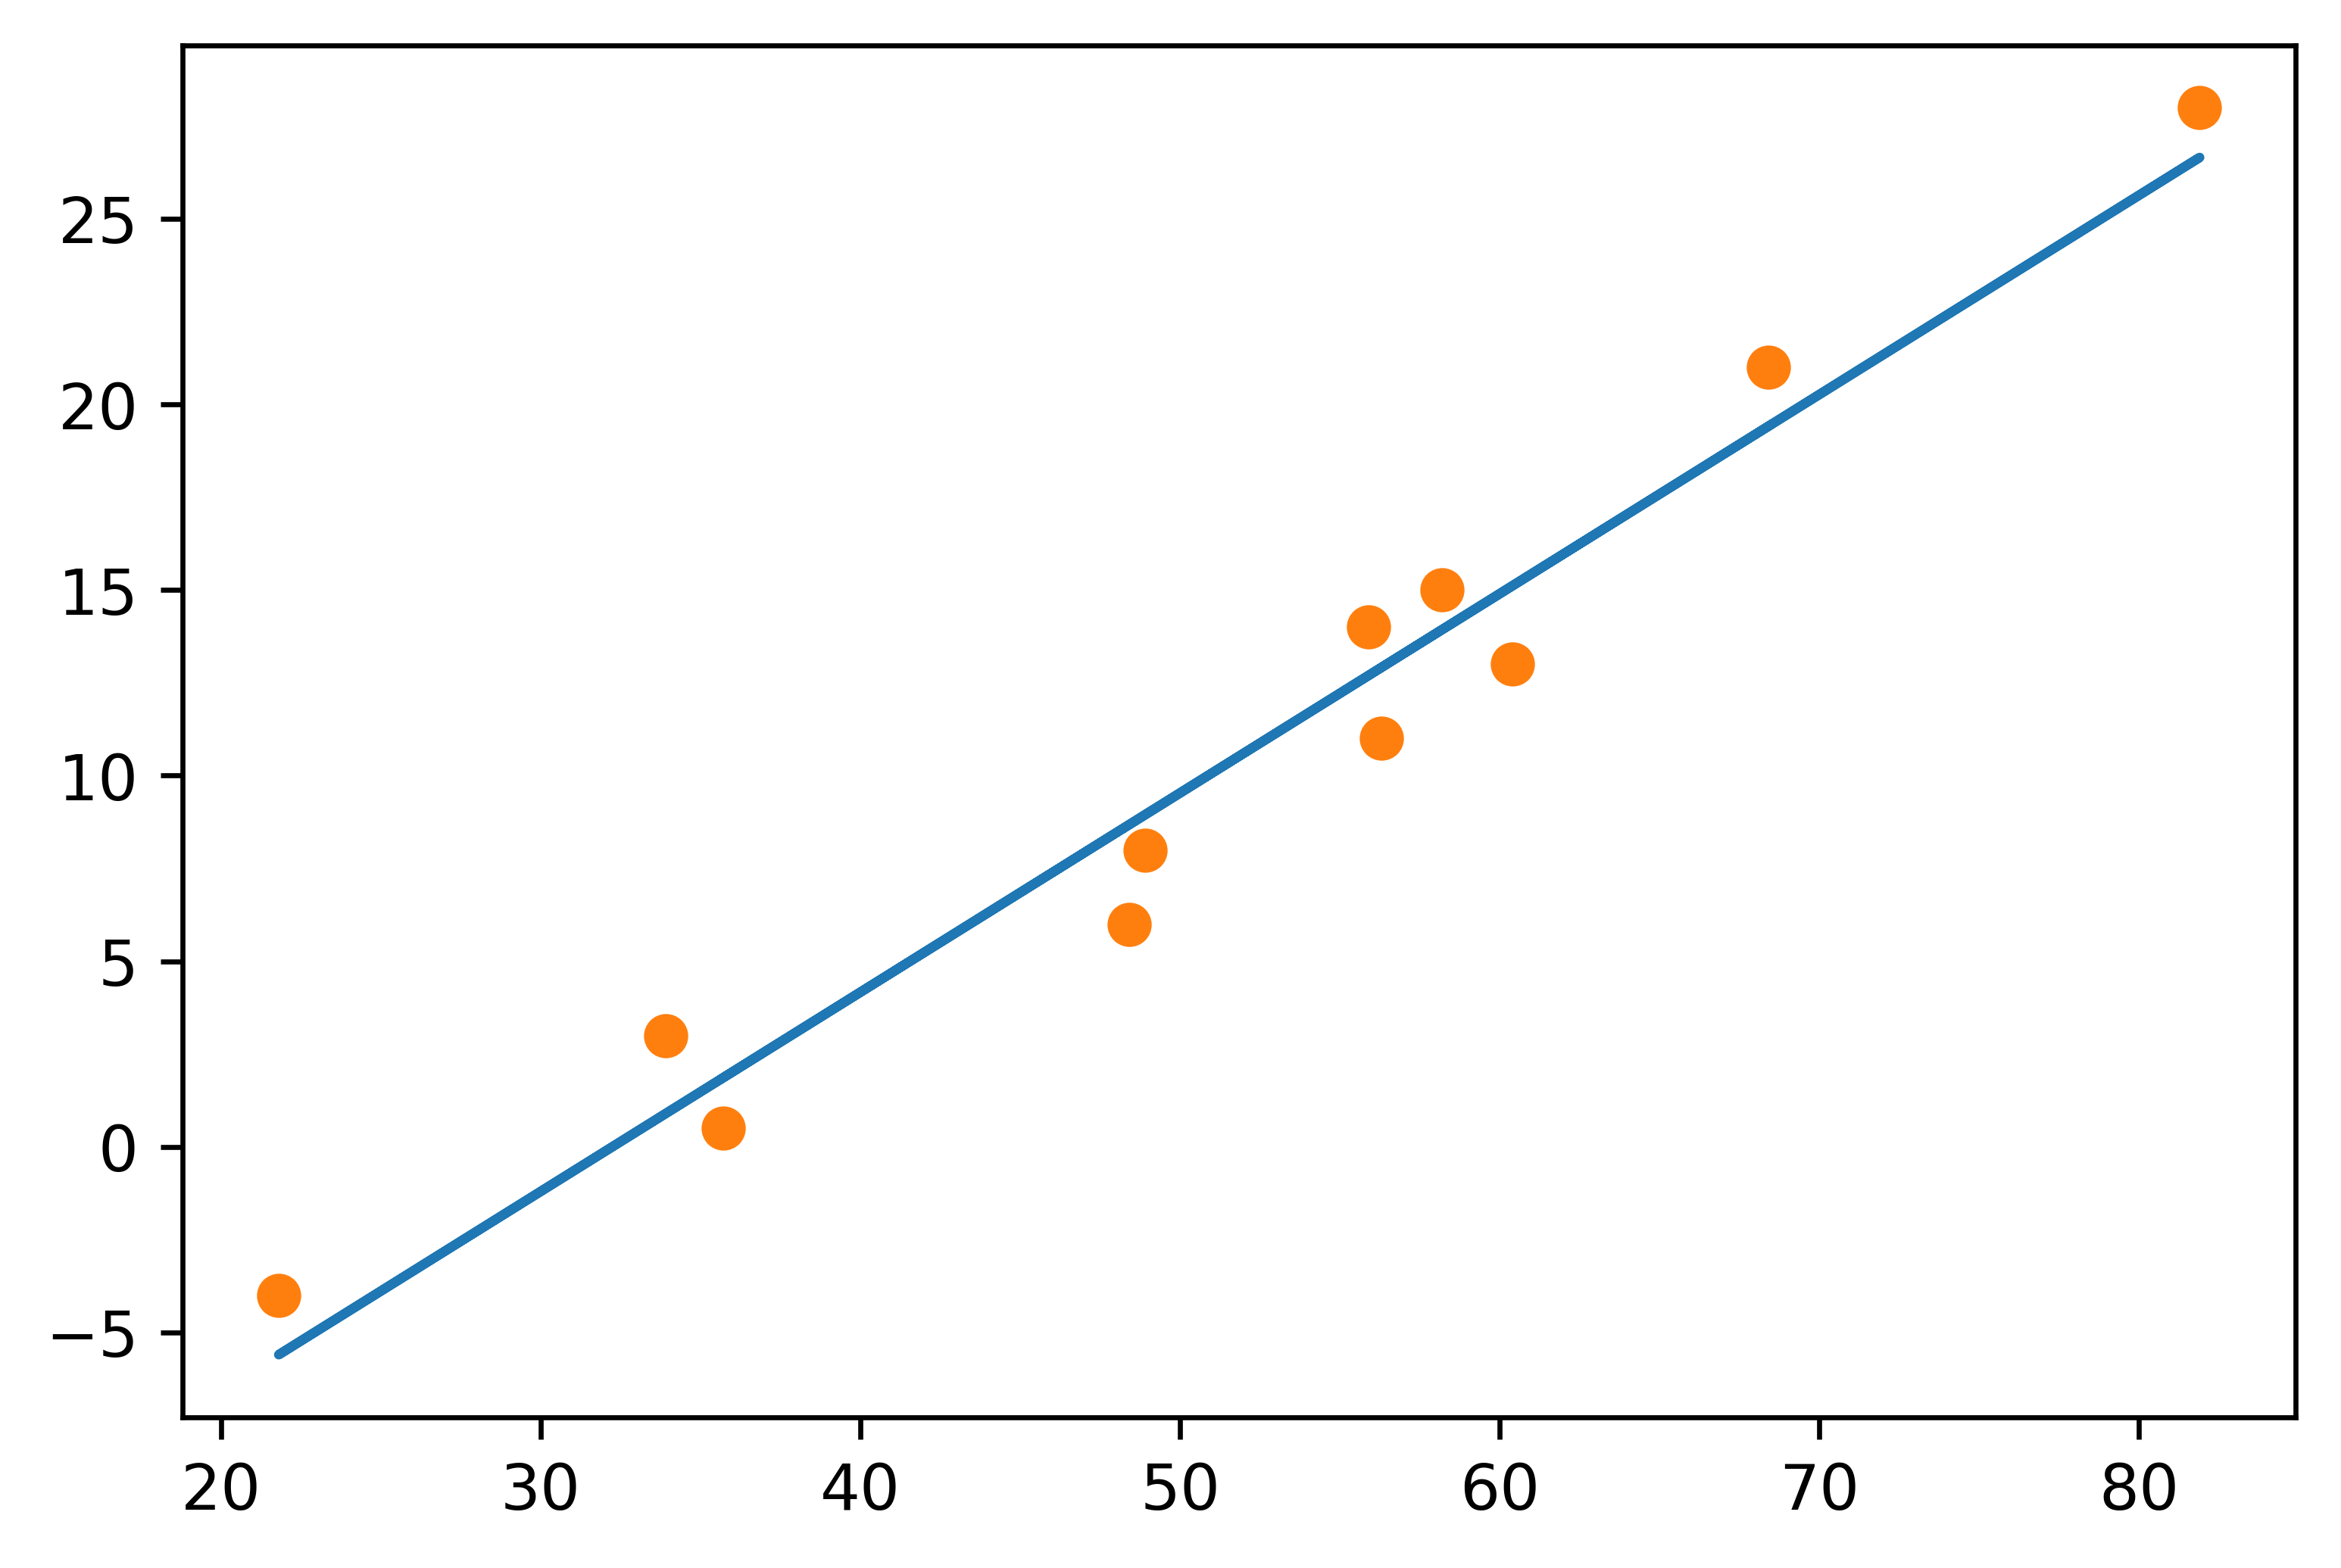

In [16]:
fig=plt.figure(dpi=600,facecolor='white')
plt.xlabel=("°Fahrenheit")
plt.ylabel=("°Celcius")
plt.plot(t_u.numpy(),t_p.detach().numpy())
plt.plot(t_u.numpy(),t_c.numpy(),'o')

### **5.2.1 Optimizers A-la Carte**
The optimizer that will be used in this section is *vanilla gradient descent*. The torch module has an optim submodule where we can find classes implementing different optimization algorithms. 

In [17]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

Each optimizer exposes two methods:
*  **'zero_grad'** zeroes the 'grad' attribute of all the parameters passed to the optimizer upon construction. 
*  **'step'** updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

In [18]:
#Creating params and instantiate a gradient descent optimizer:
params=torch.tensor([1.0,0.0],requires_grad=True)
lr=1e-5
optimizer=optim.SGD([params],lr=lr) #SGD: Stochastic Gradient Descent

In [19]:
#We use .step() to update the value of 'params'
t_p=model(t_u,*params)
loss=loss_fn(t_p,t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The optimizer looked into params.grad and updated params subtracting learning_rate times grad from it, exactly as in our former hand-rolled code.

In [20]:
#Do not forget to zero the gradients!
params=torch.tensor([1.0,0.0],requires_grad=True)
lr=1e-2
optimizer=optim.SGD([params],lr=lr)

t_p=model(t_un,*params)
loss=loss_fn(t_p,t_c)

optimizer.zero_grad()

loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [21]:
#Updated Training Loop using Optimizer
def trainingloop(n_epochs,optimizer,params,t_u,t_c): 
  #without parameter, the element would be trainingloop(n_epochs,lr,params,t_u,t_c)
  for epoch in range(1,n_epochs+1):
    t_p=model(t_u,*params) #THIS IS FORWARD PASS
    loss=loss_fn(t_p,t_c)

    optimizer.zero_grad()
    loss.backward() #THIS IS BACKWARD PASS
    optimizer.step()

    if epoch % 500 == 0:
      print('Epoch %d, Loss %f' % (epoch,float(loss)))
  
  return params

In [22]:
params=torch.tensor([1.0,0.0],requires_grad=True)
lr=1e-2
optimizer=optim.SGD([params],lr=lr)

In [23]:
params1=trainingloop(n_epochs=5000,
                     optimizer=optimizer,
                     params=params,
                     t_u=t_un,
                     t_c=t_c)

Epoch 500, Loss 7.860118
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927680
Epoch 4500, Loss 2.927651
Epoch 5000, Loss 2.927648


In [24]:
print(params)

tensor([  5.3671, -17.3012], requires_grad=True)


In [25]:
#Let's try to use Adam Optimizer
params=torch.tensor([1.0,0.0],requires_grad=True)
lr=1e-1
optimizer=optim.Adam([params],lr=lr)

In [26]:
#Let's try using the original t_u with n_epochs=2000
params2=trainingloop(n_epochs=2000,
                     optimizer=optimizer,
                     params=params,
                     t_u=t_u,
                     t_c=t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


In [27]:
print(params)

tensor([  0.5367, -17.3021], requires_grad=True)


### **5.2.2 Training, Validation, and Overfitting**
The optimizer we have learned in the previous section aims to minimize the loss at the data points. However, if we had independent data points that we didn’t use to evaluate our loss or descend along its negative gradient, we would soon find out that evaluating the loss at those independent data points would yield higher than expected loss, and this can cause *overfitting*.

In order to prevent overfitting, we need what is called *validation*. The process is taking out a few data points from our dataset and only fit our model on the remaining data points, which later be called *training set*. So, while we’re fitting the model, we can *evaluate the loss once on the training set and once on the validation set*. 



In [28]:
n_samples=t_u.shape[0]
n_val=int(0.2*n_samples) #Here, we use 20% of the data as validation set

shuffled_indices=torch.randperm(n_samples)

train_indices=shuffled_indices[:-n_val]
val_indices=shuffled_indices[-n_val:]

In [29]:
print(n_samples)

11


In [30]:
print(n_val)

2


In [31]:
print(shuffled_indices)

tensor([ 4,  1, 10,  9,  0,  8,  3,  2,  6,  5,  7])


In [32]:
print(train_indices)

tensor([ 4,  1, 10,  9,  0,  8,  3,  2,  6])


In [33]:
print(val_indices)

tensor([5, 7])


In [34]:
#Building training and validation sets
train_t_u=t_u[train_indices]
train_t_c=t_c[train_indices]

val_t_u=t_u[val_indices]
val_t_c=t_c[val_indices]

train_t_un=0.1*train_t_u
val_t_un=0.1*val_t_u

In [35]:
print(train_t_u)

tensor([56.3000, 55.9000, 68.4000, 60.4000, 35.7000, 48.4000, 81.9000,
        58.2000, 33.9000])


In [36]:
print(train_t_c)

tensor([11.0000, 14.0000, 21.0000, 13.0000,  0.5000,  6.0000, 28.0000,
        15.0000,  3.0000])


In [37]:
print(val_t_u)

tensor([48.9000, 21.8000])


In [38]:
print(val_t_c)

tensor([ 8., -4.])


In [39]:
print(train_t_un)

tensor([5.6300, 5.5900, 6.8400, 6.0400, 3.5700, 4.8400, 8.1900, 5.8200,
        3.3900])


In [40]:
print(val_t_un)

tensor([4.8900, 2.1800])


In [41]:
#The training loop is basically the same
def trainingloop(n_epochs,optimizer,params,train_t_u,val_t_u,train_t_c,val_t_c):
  for epoch in range(1,n_epochs+1):
    train_t_p=model(train_t_u,*params)
    train_loss=loss_fn(train_t_p,train_t_c)

    val_t_p=model(val_t_u,*params)
    val_loss=loss_fn(val_t_p,val_t_c)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if epoch<=3 or epoch % 500 == 0:
      print('Epoch {}, Training Loss {}, Validation Loss {}'.format(epoch,float(train_loss),float(val_loss)))
    
  return params

In [42]:
params=torch.tensor([1.0,0.0],requires_grad=True)
lr=1e-2
optimizer=optim.SGD([params],lr=lr)

In [43]:
params=trainingloop(n_epochs=3000,
                    optimizer=optimizer,
                    params=params,
                    train_t_u=train_t_un,
                    val_t_u=val_t_un,
                    train_t_c=train_t_c,
                    val_t_c=val_t_c)

Epoch 1, Training Loss 92.9048080444336, Validation Loss 23.9322509765625
Epoch 2, Training Loss 32.46635818481445, Validation Loss 36.43826675415039
Epoch 3, Training Loss 25.994892120361328, Validation Loss 46.35353088378906
Epoch 500, Training Loss 9.8406400680542, Validation Loss 11.403146743774414
Epoch 1000, Training Loss 5.113064765930176, Validation Loss 2.0224971771240234
Epoch 1500, Training Loss 3.6757571697235107, Validation Loss 0.9232907295227051
Epoch 2000, Training Loss 3.2387797832489014, Validation Loss 1.5555413961410522
Epoch 2500, Training Loss 3.1059255599975586, Validation Loss 2.2806496620178223
Epoch 3000, Training Loss 3.0655360221862793, Validation Loss 2.7949328422546387


In [44]:
print(params)

tensor([  5.5415, -18.3100], requires_grad=True)


In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
t_p=model(t_un,*params)

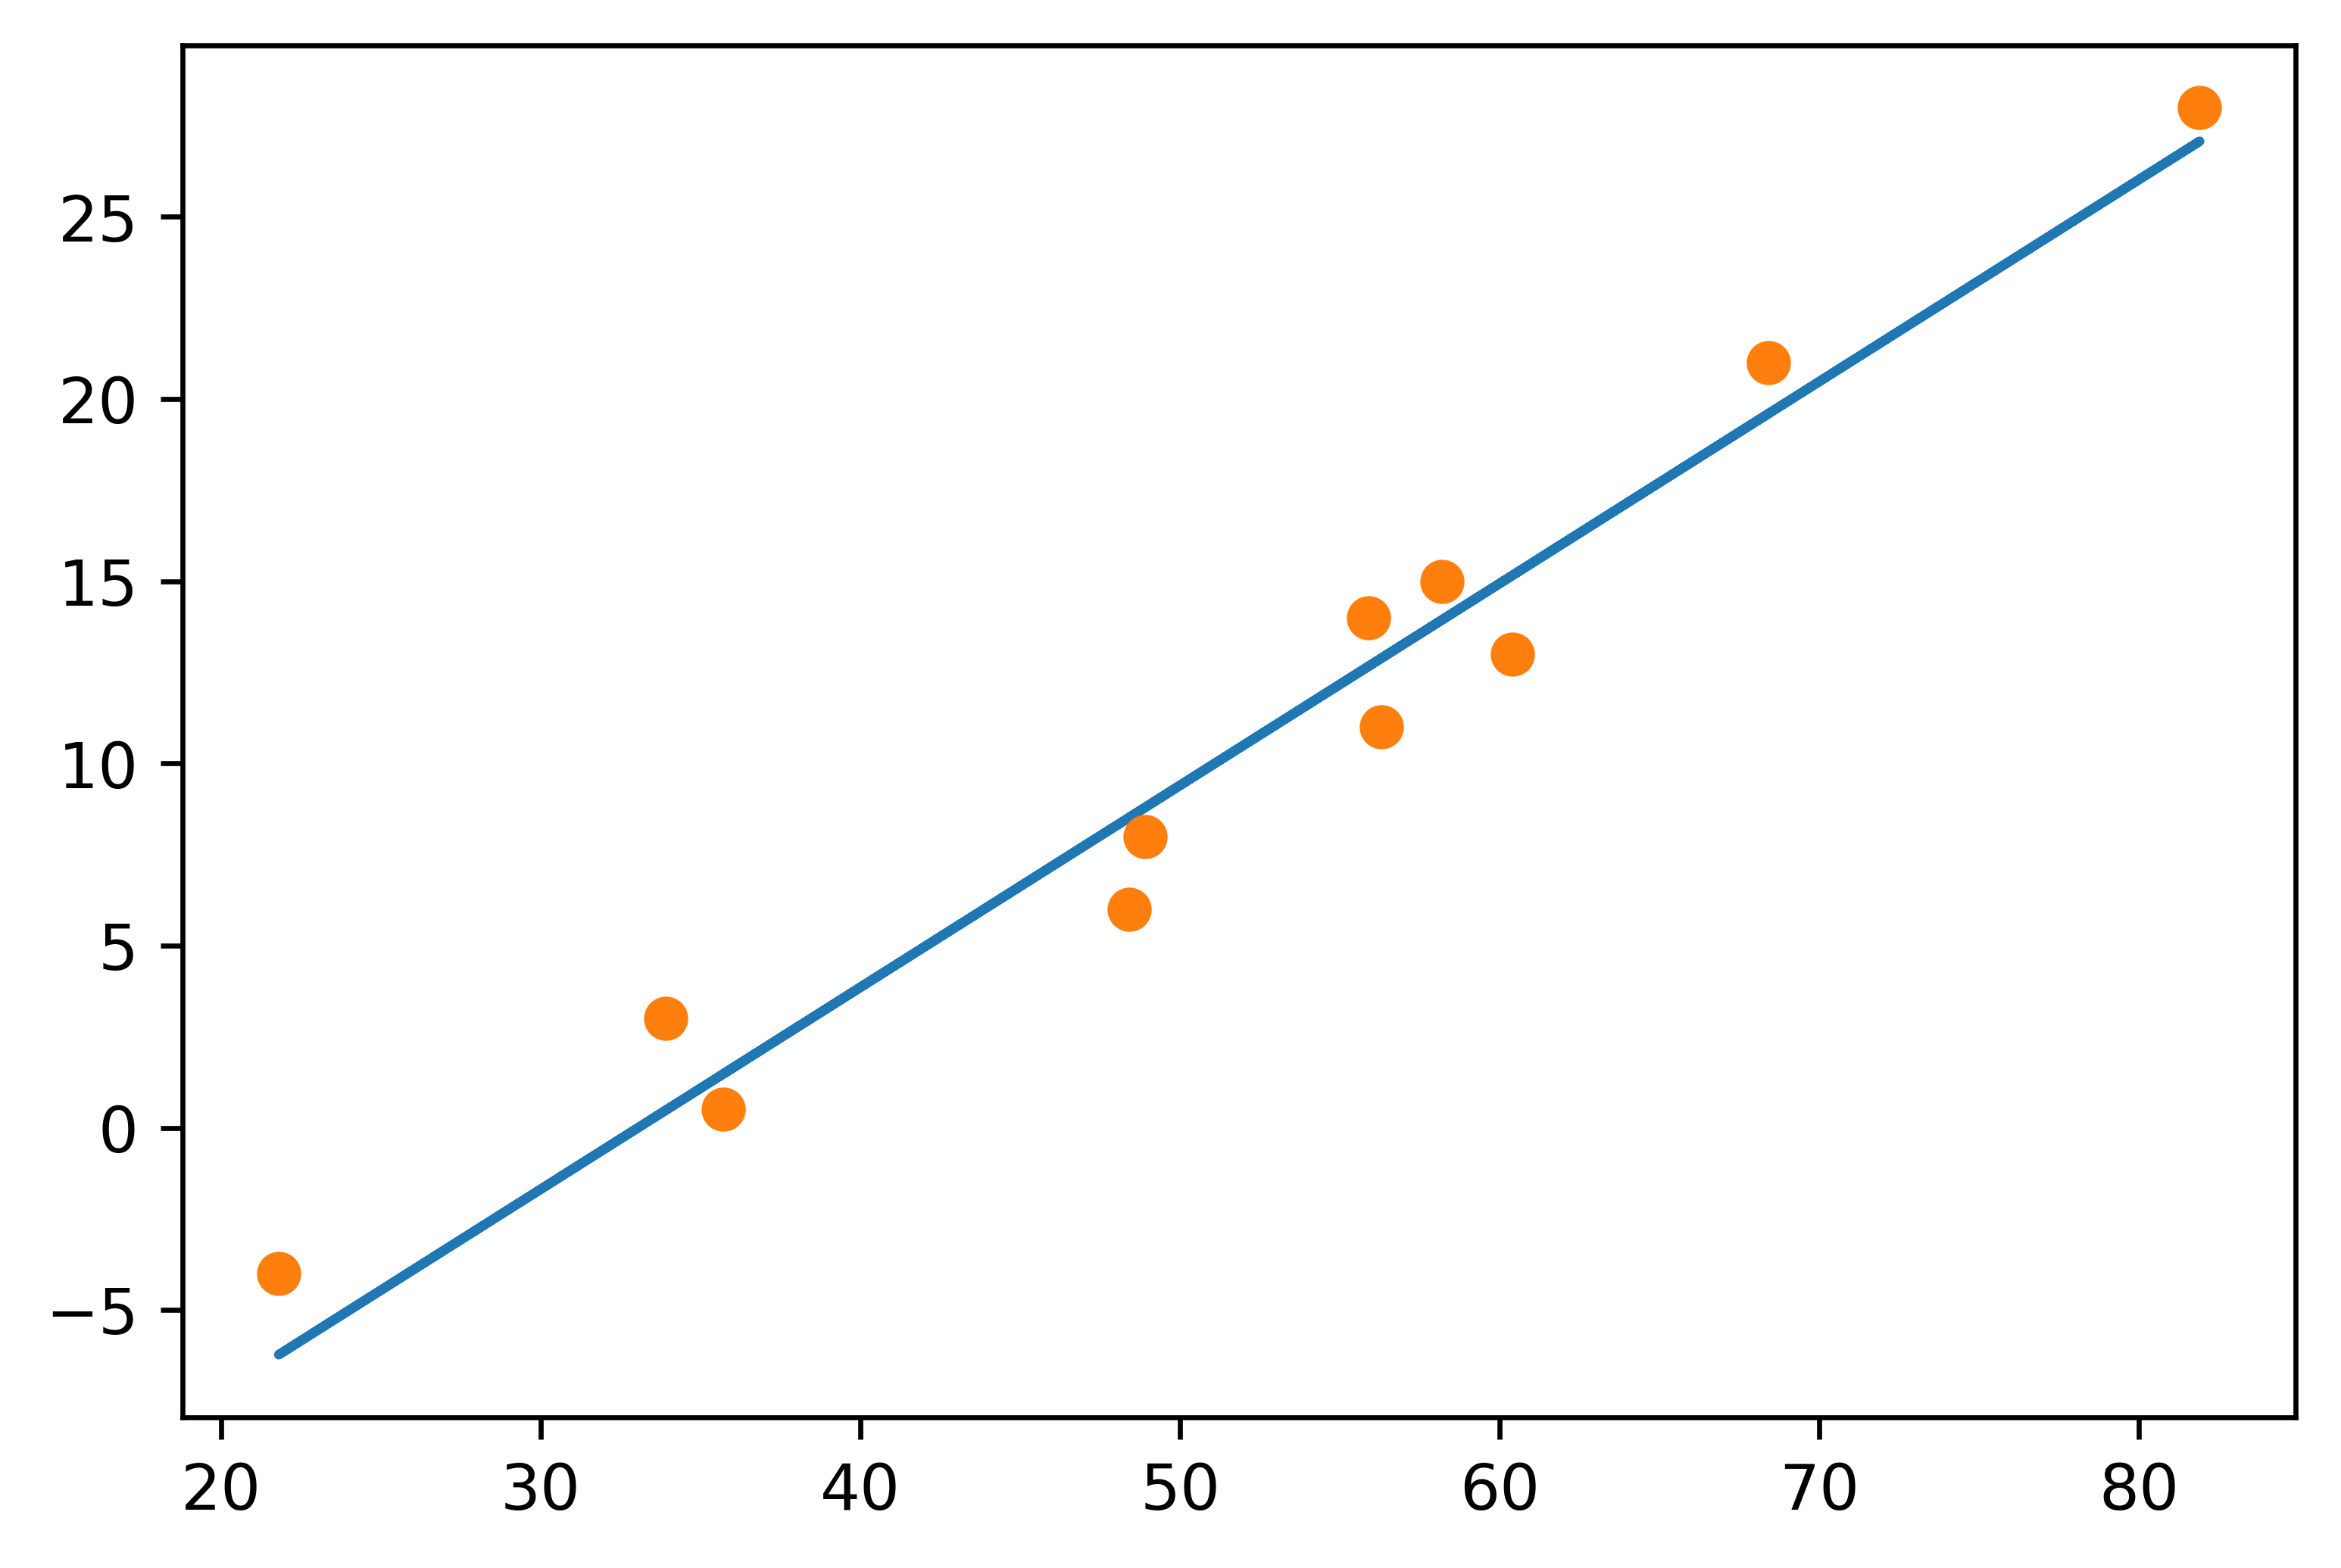

In [47]:
fig=plt.figure(dpi=600,facecolor='white')
plt.xlabel=("°Fahrenheit")
plt.ylabel=("°Celcius")
plt.plot(t_u.numpy(),t_p.detach().numpy())
plt.plot(t_u.numpy(),t_c.numpy(),'o')

### **5.2.3 Autograd Nits and Switching It Off**